In [1]:
from datetime import datetime, timedelta
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatch
import matplotlib.ticker as mticker
from matplotlib import gridspec

import heliopy.data.spice as spicedata
import heliopy.spice as spice

import sunpy.map
from sunpy.coordinates import frames


import pfsspy

import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord

import helpers

matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

In [2]:
helpers.download_gong_maps()

Generate PSP trajectory
---

In [3]:
for kernel in ['psp', 'planet_trajectories', 'planet_orientations', 'psp_pred']:
    k = spicedata.get_kernel(kernel)
    spice.furnish(k)
    
psp = spice.Trajectory('SPP')
# Create list of times
starttime = datetime(2019, 3, 27)
endtime = datetime(2019, 4, 13, 1)
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(hours=2)
    
psp.generate_positions(times, 'Sun', 'IAU_SUN')
psp.change_units(u.au)
psp_coord = coord.SkyCoord(x=psp.x, y=psp.y, z=psp.z, frame=frames.HeliographicCarrington,
                               representation_type='cartesian')
psp_coord.representation_type = 'spherical'

Project trajectory onto source surface, correcting for solar rotation
---

In [4]:
omega_sun = 14.713 * u.deg / u.d
vsw = 360 * u.km / u.s
def delta_long(r):
    return omega_sun * (r - 2.5 * const.R_sun) / vsw

psp_solar_lon = psp_coord.lon + delta_long(psp_coord.radius)
psp_solar_surface = coord.SkyCoord(radius=psp_coord.radius,
                                   lat=psp_coord.lat,
                                   lon=psp_solar_lon, frame=frames.HeliographicCarrington,
                                   representation_type='spherical')

Import GONG magnetogram data
---

Function to get $B_{r}$ from a GONG magnetogram map

In [5]:
def extract_br(m):
    br = m.data
    br = br - np.nanmean(br)
    # GONG maps have their LH edge at -180deg, so roll to get it at 0deg
    br = np.roll(br, m.meta['CRVAL1'] + 180, axis=1)
    return br

Get data for map closest to perihelion

In [6]:
gong_map = sunpy.map.Map('mrzqs190325t0904c2215_130.fits')
br = extract_br(gong_map)

Set up PFSS input and calculate PFSS solution
---

Calculate solution for perihelion map

In [7]:
nr = 60
rss = 2.5
peri_input = pfsspy.Input(br, nr, rss)
peri_output = pfsspy.pfss(peri_input)

Calculate solutions for all other maps. These are used later to asses the variability of the HCS over the perihelion time interval

In [8]:
map_fnames = helpers.gong_map_fnames()
outputs = []
for m in map_fnames:
    print(f'Processing {m}')
    m = sunpy.map.Map(m)
    br = extract_br(m)
    inp = pfsspy.Input(br, nr, rss)
    outputs.append(pfsspy.pfss(inp))

Processing mrzqs190325t0904c2215_130.fits


Trace field lines using perihelion map
---

In [9]:
flines = []
psp_solar_surface.representation_type = 'cartesian'
for i in range(0, len(psp_solar_surface.x)):
    seed = np.array([psp_solar_surface.x[i].value,
                      psp_solar_surface.y[i].value,
                      psp_solar_surface.z[i].value])
    seed = seed * 2.499 / np.linalg.norm(seed)
    fline = peri_output.trace(seed, atol=1e-6)
    flines.append(fline)

Calculate field line polarities and expansion factors
---

In [10]:
polarities = np.array([fline.polarity for fline in flines], dtype=float)
polarities[polarities == 0] = np.nan

In [11]:
expansion_factors = np.array([fline.expansion_factor for fline in flines])
expansion_factors[expansion_factors == None] = np.nan

Plot results
---

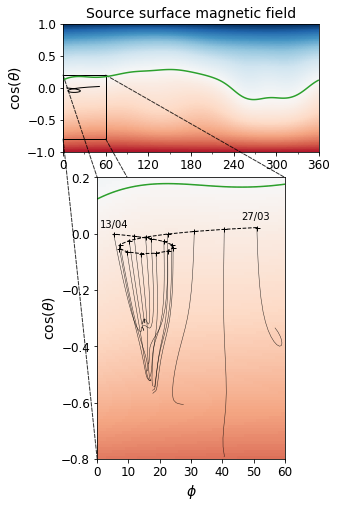

In [12]:
psp_solar_surface.representation_type = 'spherical'
fig = plt.figure(figsize=(5, 8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1:])

for ax in (ax1, ax2):
    mesh = peri_output.plot_source_surface(ax)
    peri_output.plot_pil(ax, colors='tab:green', linestyles='-')

# Only plot every 12th field line (ie. every 12 hours)
skip = 12
ax = ax2
for fline in flines[::skip]:
    color = {-1: 'tab:red', 1: 'tab:blue'}.get(fline.polarity)
    fline.representation_type = 'spherical'
    # Plot field line
    ax.plot(fline.lon, np.sin(fline.lat), color='k', linewidth=0.5, alpha=0.8)

# Plot range of PILs
for o in outputs:
    o.plot_pil(ax, colors='tab:green', linewidths=1, alpha=0.2, linestyles='--')

# Plot PSP trajectory
ax.plot(psp_solar_surface.lon[::skip],
        np.sin(psp_solar_surface.lat[::skip]),
        color='black', marker='+', lw=1, linestyle='--', ms=5)
# Add date labels for start and end point
ax.text(46, 0.05, '27/03')
ax.text(1, 0.02, '13/04')

left, right = 0, 60
bottom, top = -0.8, 0.2
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

# Add connection lines between axes
for lims in ((left, top), (right, top), (left, bottom), (right, bottom)):
    con = mpatch.ConnectionPatch(xyA=lims, xyB=lims,
                          coordsA='data', coordsB='data',
                          axesA=ax1, axesB=ax2,
                          shrinkB=0, linestyle='--', alpha=0.8)
    ax1.add_artist(con)

ax.xaxis.set_major_locator(mticker.MultipleLocator(10))

ax = ax1
# Plot PSP trajectory
ax.plot(psp_solar_surface.lon,
    np.sin(psp_solar_surface.lat),
    color='black', lw=1, linestyle='-')

# Add rectangle for zoomed box
ax.add_patch(mpatch.Rectangle((left, bottom),
                              right - left,
                              top - bottom, facecolor='none',
                              linewidth=1, edgecolor='k'))
ax.set_title('Source surface magnetic field')
    
fig.savefig('fline_mapping.pdf', bbox_inches='tight')

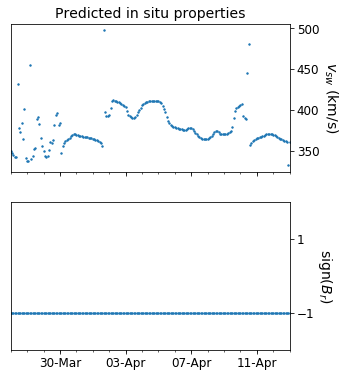

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(5, 6), sharex=True)

ax = axs[0]
ax.scatter(psp.times, 267.5 + 410 / (expansion_factors**(0.4)), s=2)
ax.set_title('Predicted in situ properties')
ax.set_ylabel('$v_{sw}$ (km/s)', rotation=-90, labelpad=20)

ax = axs[1]
ax.scatter(psp.times, polarities, s=2)
ax.set_ylabel('sign$(B_{r})$', rotation=-90, labelpad=20)
ax.set_ylim(-2, 2)

ax.yaxis.set_major_locator(mticker.FixedLocator([-1, 1]))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.set_xlim(psp.times[0], psp.times[-1])

for ax in axs:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

fig.savefig('tseries.pdf', bbox_inches='tight')